In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [1]:
import lnPi
#reload(lnPi.molfrac)

In [4]:
lnpi_bulk = lnPi.lnPi_phases.from_file('./nahs_asym_mix.07_07_07.r1.lnpi_o.dat',mu=[0.5,0.5],fill_value=np.nan,ZeroMax=True,num_phases_max=2,beta=1.0,
                                     build_kwargs=dict(num_phases_max=5),ftag_phases=lnPi.tag_phases_binary) 

In [5]:
import tqdm

In [9]:
def do_loop(x,mf,ref,phaseID=0,mu2_crit=-4.7):
    
    L = []
    error = []
    for mu2 in tqdm.tqdm(x,leave=True,desc='mf=%s'%mf):
        
        #get spinodal for phase 0
        if mu2>-mu2_crit:
            c = lnPi.lnPi_collection.from_mu(ref,[None,mu2],np.linspace(mu2-10.,mu2+10.,2))
            s,r = lnPi.spinodal.get_spinodal(c,0,full_output=True)
        else:
            s=None

        
        LB = [mu2-10,mu2]
        if s is None:
            UB = [mu2+10,mu2]
        else:
            UB = s.mu
        
       
        try:
            t,r = lnPi.molfrac.find_mu_molfrac(ref,phaseID,mf,LB,UB,full_output=True)
        except:
            error.append(mu2)
        else:
            L.append(t)
        
    return L,error
        
    

In [213]:
x1=np.arange(-10.,-5.,0.2)
x2=np.arange(-5.,4.01,0.05)
x = np.concatenate((x1,x2))

In [ ]:
for mf in [0.0025,0.005,0.01,0.02,0.04,0.05,0.08,0.1]:

    L,error = do_loop(x,mf,lnpi_bulk)
    C = lnPi.lnPi_collection(lnpis=L)
    C.to_hdf('const_molfrac.h5','bulk/molfrac_%s'%mf,ref=None,overwrite=True)

In [218]:
import utils
reload(utils)

<module 'utils' from 'utils.pyc'>

## get confined collections

In [219]:
lnpi_conf = lnPi.lnPi_phases.from_file('./nahs_asym_mix.11_11_03.r1.lnpi_o.dat',mu=[0.5,0.5],fill_value=np.nan,ZeroMax=True,num_phases_max=2,beta=1.0,
                                     build_kwargs=dict(num_phases_max=5),
                                      ftag_phases=lnPi.tag_phases_binary) 



In [220]:
!ls -lh ./const_molfrac.h5

-rw-r--r--  2 wpk  wpk   101M Jan 11 11:11 ./const_molfrac.h5


In [221]:
#read in bulk
with lnPi.h5py.File('./const_molfrac.h5') as F:
    keys = F['bulk'].keys()
    molfracs = [float(x.replace('molfrac_','')) for x in keys]
    _,Lbulk=utils.lnPi_collections_list_from_hdf(F['bulk'],ref=lnpi_bulk,collection_list=F['bulk'].keys())

In [222]:
#write Lconf to file
Lconf = []
for C in Lbulk:
    Cconf = lnPi.lnPi_collection.from_mu_iter(lnpi_conf,C.mus)
    Lconf.append(Cconf)

#write to h5
for C,key in zip(Lconf,keys):
    C.to_hdf('const_molfrac.h5','conf/%s'%key,overwrite=True)

In [223]:
#read in conf
_,Lconf = utils.lnPi_collections_list_from_hdf('./const_molfrac.h5',key='conf',ref=lnpi_conf,collection_list=keys)

In [224]:
def plot_N_vs_Omega(CB,CC,comp=0,line_label=None,ax_label=False,ax=None):
    """
    plot confined average N vs bulk Omega for all phaseIDs and specified comp
    """
    if ax is None:
        fig,ax = plt.subplots()
    
    x = -CB.Omegas_phaseIDs()[:,0]
    y1 = CC.Naves_phaseIDs[:,0,0]
    y2 = CC.Naves_phaseIDs[:,1,0]

    
    l,=plt.plot(x,y1,label=line_label)
    plt.plot(x,y2,color=l.get_color())
    
    if ax_label:
        ax.set_xlabel(r'$-\Omega^{ex}$')
        ax.set_ylabel(r'$\langle N_1 \rangle$')
            

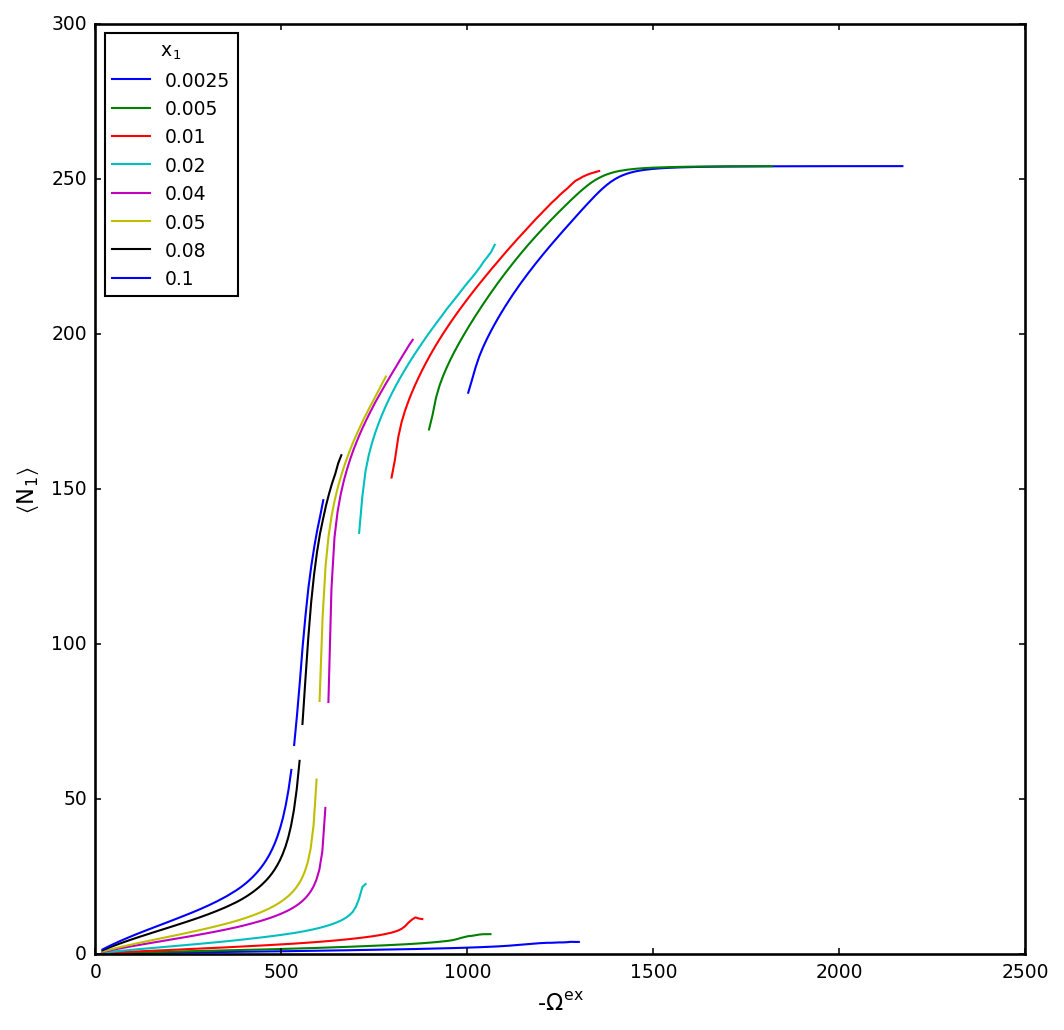

In [225]:
fig,ax = plt.subplots(figsize=(8,8))


for mf,Cbulk,Cconf in zip(molfracs,Lbulk,Lconf):
    
    plot_N_vs_Omega(Cbulk,Cconf.merge_phases(),line_label=mf,ax=ax)

ax.set_xlabel(r'$-\Omega^{ex}$')
ax.set_ylabel(r'$\langle N_1 \rangle$')
ax.legend(loc=0,title=r'$x_1$')    


In [226]:
#paths

In [227]:
bulk_bino = pd.read_hdf('bulk.h5','df_binodal')
bulk_spin = pd.read_hdf('bulk.h5','df_spinodal')

conf_bino = pd.read_hdf('conf_asym.h5','df_binodal')
conf_spin = pd.read_hdf('conf_asym.h5','df_spinodal')

In [228]:
bulk_bino.head()

,binodalID,molfrac_0,molfrac_1,mu_0,mu_1,omega,phaseID
0,0,0.260987,0.739013,-4.690808,-4.4,-465.009279,0
1,0,0.762079,0.237921,-4.690808,-4.4,-465.009279,1
2,0,0.190165,0.809835,-4.506542,-4.2,-491.957306,0
3,0,0.832899,0.167101,-4.506542,-4.2,-491.957306,1
4,0,0.128952,0.871048,-4.322718,-4.0,-520.032280,0


In [229]:
bulk_spin.head()

,molfrac_0,molfrac_1,mu_0,mu_1,omega,phaseID
0,0.267927,0.732073,-4.694870,-4.4,-464.921850,0
1,0.764867,0.235133,-4.686116,-4.4,-465.545994,1
2,0.210037,0.789963,-4.481690,-4.2,-492.584154,0
3,0.815765,0.184235,-4.526232,-4.2,-489.504052,1
4,0.170031,0.829969,-4.259699,-4.0,-521.301780,0


In [230]:
reload(utils)

<module 'utils' from 'utils.pyc'>

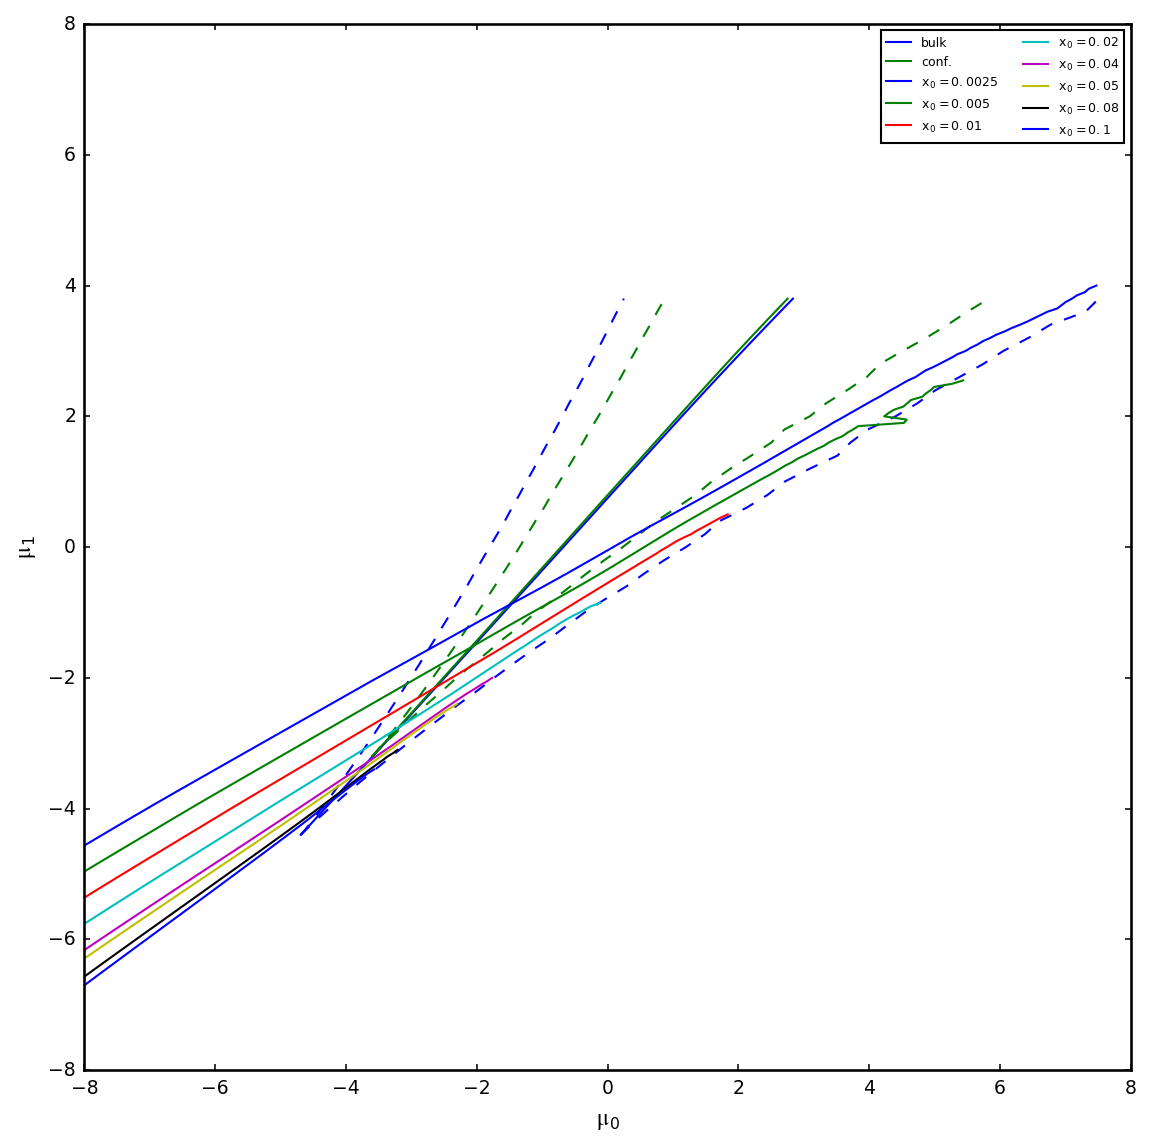

In [231]:
fig,ax = plt.subplots(figsize=(9,9))
ax=utils.plot_mu0_vs_mu1(bulk_bino,bulk_spin.query('phaseID<2'),colors=['b']*3,line_labels=['bulk',None,None],ax=ax)
ax=utils.plot_mu0_vs_mu1(conf_bino,conf_spin.query('phaseID<2'),colors=['g']*3,ax=ax,ax_labels=True,
                         line_labels=['conf.',None,None])

for mf,Cbulk in zip(molfracs,Lbulk):
    mu1,mu2 = Cbulk.mus.T
    plt.plot(mu1,mu2,label=r'$x_0=%s$'%mf)
    #break
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
    
ax.legend(loc=0,fontsize=6,ncol=2)


In [232]:
mus = C.mus.T

(0, 1)

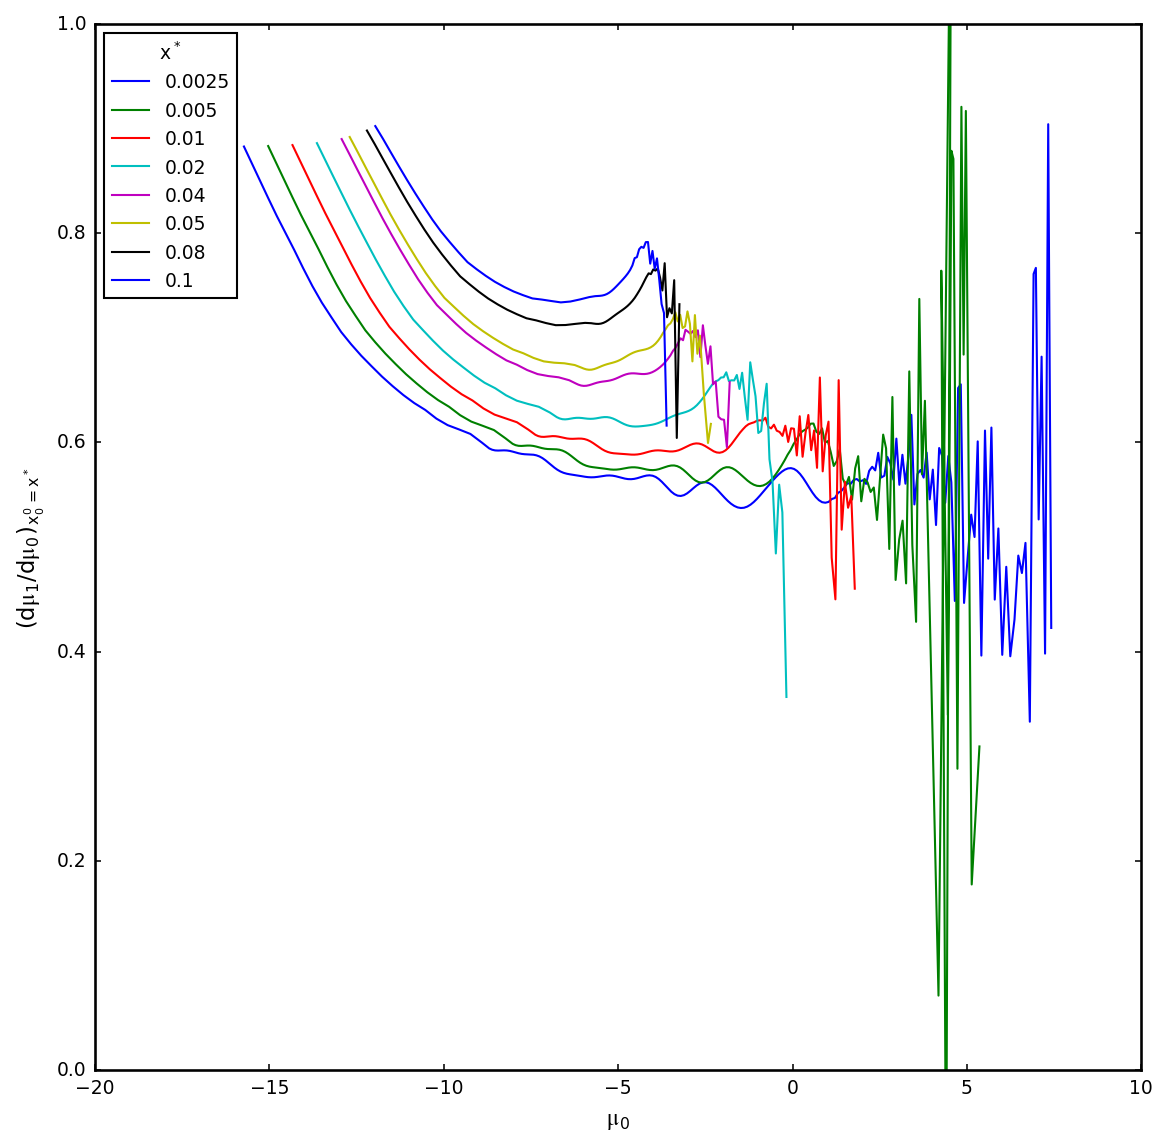

In [233]:
fig,ax = plt.subplots(figsize=(9,9))
ax.set_xlabel(r'$\mu_0$')
ax.set_ylabel(r'$(d\mu_1/d\mu_0)_{x^0_0=x^*}$')
for mf,C in zip(molfracs,Lbulk):
    mus=C.mus.T

    d1d0 = np.diff(mus[1])/np.diff(mus[0])

    mus_mid = 0.5*(mus[:,1:]+mus[:,:-1])
    plt.plot(mus_mid[0],d1d0,label=mf)
    #plt.plot(mus_mid[1],1./d1d0)
    
ax.legend(loc=0,title=r'$x^*$')
ax.set_ylim(0,1)